In [25]:
import pandas as pd
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


### GET DATA

In [26]:
df = pd.read_csv('smile-annotations-final.csv', header=None,
                names=['tweetid', 'text', 'emotions'])
df.head()


,tweetid,text,emotions
0,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,614877582664835073,@Sofabsports thank you for following me back. ...,happy
4,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [27]:
# see if tweet ids are unique
len(df['tweetid'].unique()), len(df)


(3085, 3085)

In [28]:
# set index
df.set_index('tweetid', inplace=True)


### EDA

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|angry               2
sad|disgust             2
sad|disgust|angry       1
Name: emotions, dtype: int64


Text(0.5, 1.0, 'Emotions')

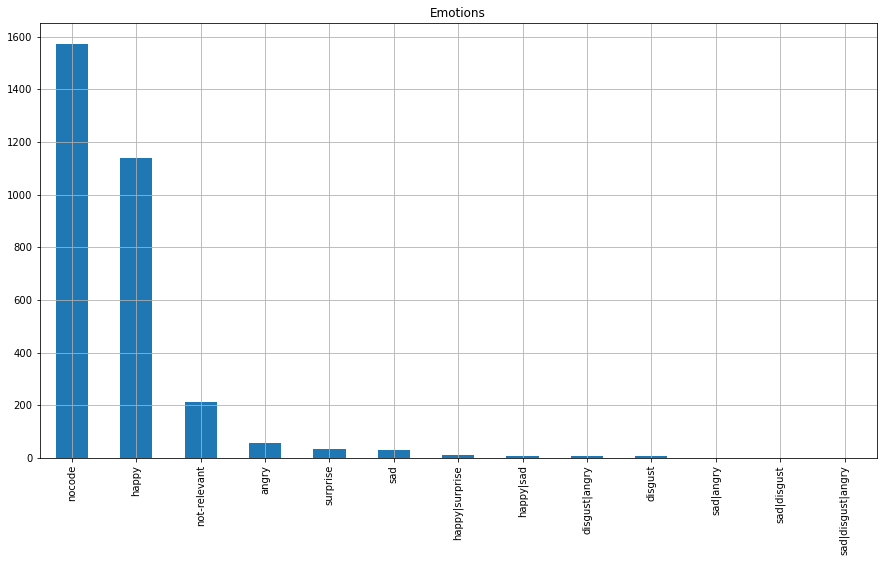

In [29]:
print(df.emotions.value_counts())
df['emotions'].value_counts().plot(figsize=(15, 8), kind='bar')
plt.grid(True)
plt.title('Emotions')


In [30]:
# drop 'nocode' and multiple-emotion categories,
df = df[df['emotions'] != 'nocode']
df = df[~df['emotions'].str.contains('\|')]


In [31]:
df['category'] = pd.factorize(df['emotions'])[0]
df.head()

,text,emotions,category
tweetid,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


### TRAIN/VALIDATION SPLIT

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    df.text,
    df.category,
    test_size=0.15,
    random_state=17,
    stratify=df.category.values)


In [33]:
df['data_type'] = ['NA'] * len(df)
df.loc[X_train.index, 'data_split'] = 'train'
df.loc[X_val.index, 'data_split'] = 'val'

df.groupby(['emotions', 'category', 'data_split']).count()


text  data_type
emotions     category data_split                 
angry        2        train         48         48
                      val            9          9
disgust      3        train          5          5
                      val            1          1
happy        0        train        966        966
                      val          171        171
not-relevant 1        train        182        182
                      val           32         32
sad          4        train         27         27
                      val            5          5
surprise     5        train         30         30
                      val            5          5

## Tokenize/encode

In [34]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df['data_split'] == 'train']['text'].values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

encoded_data_val = tokenizer.batch_encode_plus(
    df[df['data_split'] == 'val']['text'].values,
    add_special_tokens=True,
    return_attention=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt')

indices_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
cats_train = torch.tensor(df[df['data_split'] == 'train']['category'].values)

indices_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
cats_val = torch.tensor(df[df['data_split'] == 'val']['category'].values)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/naziko/opt/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2136: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'re

Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'return_attention': True} not recognized.
Keyword arguments {'retu

In [35]:
df_train = TensorDataset(indices_train,
                        attention_masks_train,
                        cats_train)
df_val = TensorDataset(indices_val,
                      attention_masks_val,
                      cats_val)

In [36]:
len(df_train), len(df_val)

(1258, 223)

## BERT pretrained model

In [37]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(df['category'].unique()),
    output_attentions=False,
    output_hidden_states=False
    )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Data Loaders

In [38]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4

dl_train = DataLoader(df_train,
                      sampler=RandomSampler(df_train),
                      batch_size=batch_size)

dl_val = DataLoader(df_val,
                    sampler=RandomSampler(df_val),
                    batch_size=32)


## Optimizer and Scheduler

In [39]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr=1e-5,
                 eps=1e-8)

epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dl_train)*epochs
)

## Performance metrics

In [59]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(pred, category):
    pred_flat = np.argmax(pred, axis=1).flatten()
    category_flat = category.flatten()
    
    return f1_score(category_flat, pred_flat, average='weighted')

cat_dict_inverse = {}
    
for cat in df['category'].unique():
    cat_dict_inverse[cat] = df[df['category'] == cat]['emotions'].iloc[0]
        
        
def accuracy_per_class(pred, category):
    
    
    pred_flat = np.argmax(pred, axis=1).flatten()
    category_flat = category.flatten()
    
    for cat in np.unique(category_flat):
        y_pred = pred_flat[category_flat == cat]
        y_true = category_flat[category_flat == cat]
        
        print(f'Class: {cat_dict_inverse[cat]}')
        print(f'Accuracy: {len(y_pred[y_pred == cat])}/{len(y_true)}\n')
    

## Training

In [41]:
import random

seed = 17
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)


cpu


In [48]:
def evaluate(dl_val):
    
    model.eval()
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dl_val:
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        
        logits = logits.detach().cpu().numpy()
        category_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(category_ids)
        
    loss_val_avg = loss_val_total/len(dl_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    return loss_val_avg, predictions, true_vals


In [ ]:
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dl_train,
                       desc='Epoch {:1d}'.format(epoch),
                       leave=False,
                       disable=False)
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
     

In [51]:
torch.save(model.state_dict(), f'BERT_ft_epoch{epoch}.model')

tqdm.write('\nEpoch {epoch}')

loss_train_avg = loss_train_total/len(dl_train)
tqdm.write(f'Training loss: {loss_train_avg}')

val_loss, predictions, true_vals = evaluate(dl_val)
val_f1 = f1_score_func(predictions, true_vals)
tqdm.write(f'Valdation loss: {val_loss}')
tqdm.write(f'F1 Score (weighted): {val_f1}')


Epoch {epoch}
Training loss: 0.018273504548484372
Valdation loss: 0.7002162379877908
F1 Score (weighted): 0.8643009149471824


## Load and Evaluate the model

In [52]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                     num_labels=len(cat_dict_inverse),
                                                     output_attentions=False,
                                                     output_hidden_states=False)

model.to(device)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [60]:
model.load_state_dict(torch.load('BERT_ft_epoch10.model',
                                map_location=torch.device('cpu')))

_, predictions,true_vals = evaluate(dl_val)

accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 164/171

Class: not-relevant
Accuracy: 19/32

Class: angry
Accuracy: 7/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 2/5

Class: surprise
Accuracy: 2/5

